# State Estimation:Induction Motor

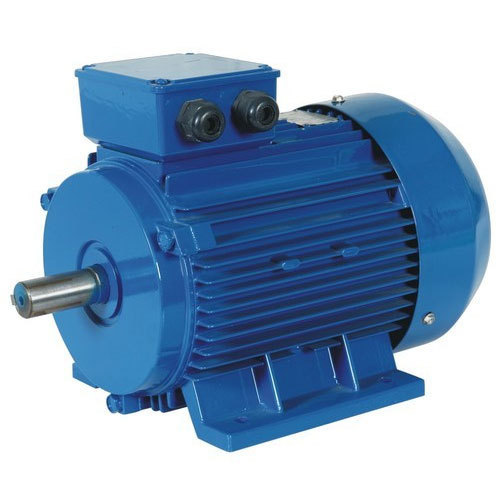

### Dhruv Ishan Bhardwaj
### 170070055
### CL 653 Autumn 2020

# State Space Model

### 5 states

<span style="color:cyan">
    
$\frac{dx_1}{dt}= k_1 x_1 + z_1 x_2+k_2 x_3+z_2$

$\frac{dx_2}{dt}= -z_1x_1+k_1x_2+k_2x_4$

$\frac{dx_3}{dt}= k_3 x_1 + k_4x_3+(z_1-x_5)x_4$

$\frac{dx_4}{dt}= k_3 x_2 - (z_1-x_5)x_3+k_4x_4$

$\frac{dx_5}{dt}= k_5 (x_1x_4-x_2x_3)+k_6z_3$

</span>

### 2 measurements

<span style="color:pink">
    
$y_1=k_7x_1+k_8x_3$

$y_2=k_7x_2+k_8x_4$

</span>

### Values of constants


| $k_1$  |  $k_2$  |  $k_3$  |  $k_4$  |  $k_5$  |  $k_6$  |  $k_7$  |  $k_8$  |  $z_1$  |  $z_2$  |  $z_3$  |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
|-0.186  |0.178    |0.225    |-0.234   |-0.081   |4.643    |   -4.448|    1    |    1    |    1    |    0    |


### Initial states

<span style="color:yellow">
    
$x(0)=[0.2, -0.6, -0.4, 0.1, 0.3]^T$ : Initial State

$Q=10^{-4}I_{5x5}$ : Model Noise

$R=10^{-2}I_{2x2}$ : Measurement Noise

$T_s=0.1s$ : Time Step

$P(0|0)=I_{5x5}$ : Initial Covariance Estimate

</span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot as jlt
jlt.style()
from math import *
import random
import scipy.linalg as sp
random.seed(1)
import scipy.stats

In [2]:
class IMotor(object):
    
    def __init__(self):
        
        #States
        self.x1=0.2
        self.x2=-0.6
        self.x3=-0.4
        self.x4=0.1
        self.x5=0.3
        
        #Parameters
        self.k1=-0.186
        self.k2=0.178
        self.k3=0.225
        self.k4=-0.234
        self.k5=-0.081
        self.k6=4.643
        self.k7=-4.448
        self.k8=1
        
    def y1(self):
        return self.k7*self.x1+self.k8*self.x3
    
    def y2(self):
        return self.k7*self.x2+self.k8*self.x4
    
    def dxdt(self, z):
        
        z1=z[0]
        z2=z[1]
        z3=z[2]
        
        dx1dt = self.k1*self.x1 + z1*self.x2 + self.k2*self.x3 + z2
        dx2dt = -z1*self.x1 + self.k1*self.x2 + self.k2*self.x4
        dx3dt = self.k3*self.x1 + self.k4*self.x3 + (z1-self.x5)*self.x4
        dx4dt = self.k3*self.x2 - (z1-self.x5)*self.x3 + self.k4*self.x4
        dx5dt = self.k5*(self.x1*self.x4-self.x2*self.x3)+self.k6*z3
        
        return np.array([dx1dt, dx2dt, dx3dt, dx4dt, dx5dt])
        
    def setState(self, X):
        self.x1=X[0]
        self.x2=X[1]
        self.x3=X[2]
        self.x4=X[3]
        self.x5=X[4]
        
    def setX5(x5):
        self.x5=x5
    
        
    def getState(self):
        
        return np.array([self.x1, self.x2, self.x3, self.x4, self.x5])
    
    def update(self, delt, z, noise=False):
        #Use RK4 method to integrate
        
        #Initialise
        h=delt
        X0=self.getState()
        
        #K1 terms
        K1=h*self.dxdt(z)
        X1=X0+K1/2
        self.setState(X1)
        
        #K2 terms
        K2=h*self.dxdt(z)
        X2=X0+K2/2
        self.setState(X2)
        
        #K3 terms
        K3=h*self.dxdt(z)
        X3=X0+K3
        self.setState(X3)
        
        #K4 terms
        K4=h*self.dxdt(z)
        X=X0+K1/6+K2/3+K3/3+K4/6
        if noise==True:
            R=np.identity(5)*1e-4
            X+=np.random.multivariate_normal([0, 0, 0, 0, 0], R)
        self.setState(X)
        
    def update2(self, delt, z, noise=False):
        
        X=self.getState()
        X+=delt*self.dxdt(Z)
        if noise==True:
            R=np.identity(5)*1e-4
            X+=np.random.multivariate_normal([0, 0, 0, 0, 0], R)
        self.setState(X)
        
        
    def linMod(self, Z):
        
        Z1=Z[0]
        Z2=Z[1]
        Z3=Z[2]
        
        X=self.getState()
        X1=X[0]
        X2=X[1]
        X3=X[2]
        X4=X[3]
        X5=X[4]
        
        a1=[self.k1, Z1, self.k2, 0, 0]
        a2=[-Z1, self.k1, 0, self.k2, 0]
        a3=[self.k3, 0, self.k4, (Z1-X5), -X4]
        a4=[0, self.k3, -(Z1-X5), self.k4, X3]
        a5=[self.k5*X4, -self.k5*X3, -self.k5*X2, self.k5*X1, 0]
        
        A=[a1, a2, a3, a4, a5]
        A=np.array(A)
        
        c1=[X2, 1, 0]
        c2=[-X1, 0, 0]
        c3=[X4, 0, 0]
        c4=[-X3, 0, 0]
        c5=[0, 0, self.k6]
        
        D=[c1, c2, c3, c4, c5]
        D=np.array(D)
        
        return A, D
        
    def meas(self, noise=True):
        
        x=self.getState()
        y1=self.k7*x[0]+self.k8*x[2]
        y2=self.k7*x[1]+self.k8*x[3]
        Y=np.array([y1, y2])
        
        if noise:
            R=np.identity(2)*1e-2
            Y+=np.random.multivariate_normal([0, 0], R)
        
        return Y
    
    def linMeas(self):
        
        y1=[self.k7, 0, self.k8, 0, 0]
        y2=[0, self.k7, 0, self.k8, 0]
        
        
        C=[y1, y2]
        
        return np.array(C)
        

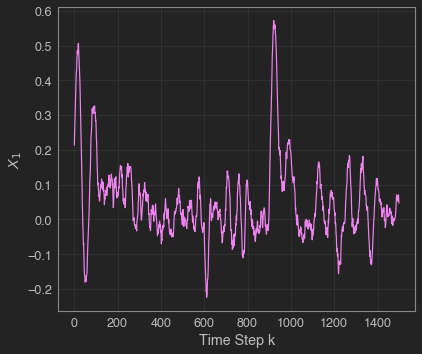

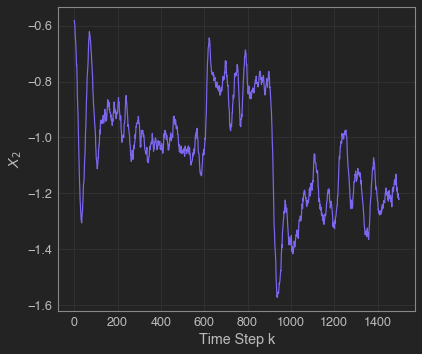

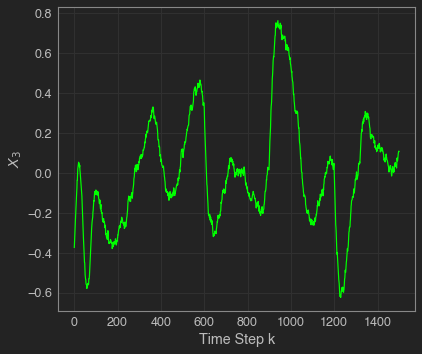

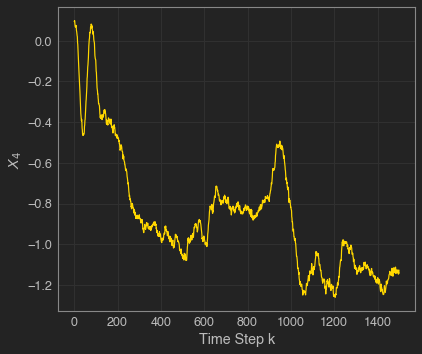

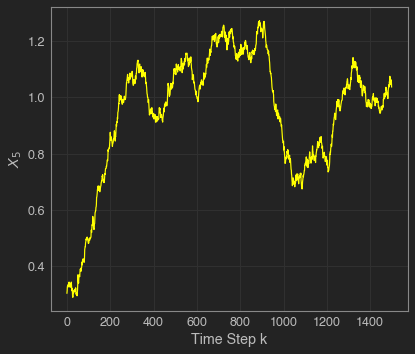

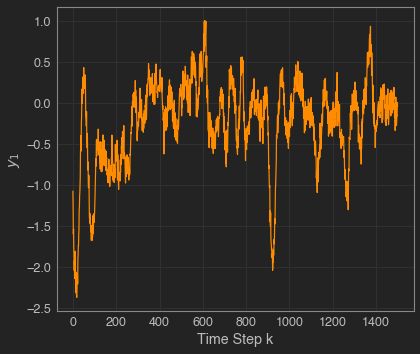

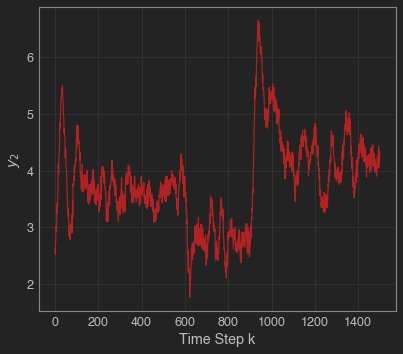

In [3]:
a=IMotor()
Xall=[]
U1=[]
U2=[]
Y1=[]
Y2=[]
C=a.linMeas()
for i in range(0, 600):
    U1.append(1)
    U2.append(1)
    a.update(0.1, [U1[i], U2[i], 0], True)
    X=a.getState()
    Xall.append(X)
    y=a.meas(True)
    Y1.append(y[0])
    Y2.append(y[1])
    
for i in range(600, 900):
    U1.append(1.2)
    U2.append(1)
    a.update(0.1, [U1[i], U2[i], 0], True)
    X=a.getState()
    Xall.append(X)
    y=a.meas(True)
    Y1.append(y[0])
    Y2.append(y[1])
    
for i in range(900, 1200):
    U1.append(0.8)
    U2.append(1)
    a.update(0.1, [U1[i], U2[i], 0], True)
    X=a.getState()
    Xall.append(X)
    y=a.meas(True)
    Y1.append(y[0])
    Y2.append(y[1])
    
for i in range(1200, 1500):
    U1.append(1)
    U2.append(1.2)
    a.update(0.1, [U1[i], U2[i], 0], True)
    X=a.getState()
    Xall.append(X)
    y=a.meas(True)
    Y1.append(y[0])
    Y2.append(y[1])
    
Xall=np.array(Xall)

plt.plot(Xall[:, 0], 'violet')
plt.xlabel('Time Step k')
plt.ylabel('$X_1$')
plt.savefig('X1s.png')
plt.show()
plt.plot(Xall[:, 1], 'mediumslateblue')
plt.xlabel('Time Step k')
plt.ylabel('$X_2$')
plt.savefig('X2s.png')
plt.show()
plt.plot(Xall[:, 2], 'lime')
plt.xlabel('Time Step k')
plt.ylabel('$X_3$')
plt.savefig('X3s.png')
plt.show()
plt.plot(Xall[:, 3], 'gold')
plt.xlabel('Time Step k')
plt.ylabel('$X_4$')
plt.savefig('X4s.png')
plt.show()
plt.plot(Xall[:, 4], 'yellow')
plt.xlabel('Time Step k')
plt.ylabel('$X_5$')
plt.savefig('X5s.png')
plt.show()


plt.plot(Y1, 'darkorange')
plt.xlabel('Time Step k')
plt.ylabel('$y_1$')
plt.savefig('Y1.png')
plt.show()


plt.plot(Y2, 'firebrick')
plt.xlabel('Time Step k')
plt.ylabel('$y_2$')
plt.savefig('Y2.png')
plt.show()

### Motor Model

In [4]:
def dxdt(X, z, t=0):
    
    k1=-0.186
    k2=0.178
    k3=0.225
    k4=-0.234
    k5=-0.081
    k6=4.643
        
    z1=z[0]
    z2=z[1]
    z3=z[2]
    
    x1=X[0]
    x2=X[1]
    x3=X[2]
    x4=X[3]
    x5=X[4]
        
    dx1dt = k1*x1 + z1*x2 + k2*x3 + z2
    dx2dt = -z1*x1 + k1*x2 + k2*x4
    dx3dt = k3*x1 + k4*x3 + (z1-x5)*x4
    dx4dt = k3*x2 - (z1-x5)*x3 + k4*x4
    dx5dt = k5*(x1*x4-x2*x3)+k6*z3
        
    return np.array([dx1dt, dx2dt, dx3dt, dx4dt, dx5dt])

def Gx(X):
    
    x1=X[0]
    x2=X[1]
    x3=X[2]
    x4=X[3]
    
    k7=-4.448
    k8=1
    
     
    y1 = k7*x1 + k8*x3
    y2 = k7*x2 + k8*x4
    
    return np.array([y1, y2])

In [5]:
def RK4(dxdt, Xi, t, dt, u):
    
    K1=dt*dxdt(Xi, t, u)
    K2=dt*dxdt(Xi+K1/2, t+dt/2, u)
    K3=dt*dxdt(Xi+K2/2, t+dt/2, u)
    K4=dt*dxdt(Xi+K3, t+dt, u)
    
    Xn=Xi+K1/6+K2/3+K3/3+K4/6
    
    return Xn

In [6]:
def IMlin(x, z):
    
    k1=-0.186
    k2=0.178
    k3=0.225
    k4=-0.23
    k5=-0.081
    k6=4.643
    
    dx1=np.array([k1, z[0], k2, 0, 0])
    dx2=np.array([-z[0], k1, 0, k2, 0])
    dx3=np.array([k3, 0, k4, z[0]-x[4], -x[3]])
    dx4=np.array([0, k3, -(z[0]-x[4]), k4, x[2]])
    dx5=np.array([k5*x[3], -k5*x[2], -k5*x[1], k5*x[0], 0])
    
    A=np.array([dx1, dx2, dx3, dx4, dx5])
    
    dz1=np.array([x[1], 1, 0])
    dz2=np.array([-x[0], 0, 0])
    dz3=np.array([x[3], 0, 0])
    dz4=np.array([-x[2], 0, 0])
    dz5=np.array([0, 0, k6])
    
    B=[dz1, dz2, dz3, dz4, dz5]
    B=np.array(B)
    
    C=np.identity(5)
    return A, B, C

def IMeas(x):
    
    k7=-4.448
    k8=1
    
    y1=np.array([k7, 0, k8, 0, 0])
    y2=np.array([0, k7, 0, k8, 0])
    
    C=[y1, y2]
    
    return np.array(C)
    

In [7]:
def genSigma(X, P):
    
    M=len(X)
    
    if M>=3:
        K=1
    else:
        K=3-M
        
    
    p=sqrt(M+K)
    x=np.zeros([M, 2*M+1])
    x[:, 0]=X
    for i in range(0, M):
        a=P[i]
        for j in range(0, len(a)):
            if a[j]<0:
                a[j]=0
        x[:, i+1]=X+p*np.sqrt(a)
        x[:, i+M+1]=X-p*np.sqrt(a)
        
    return np.array(x)

def Fx(Xi, dt, Z):
    
    a=IMotor()
    a.setState(Xi)
    a.update(dt, Z)
    return a.getState()


def Gx(X):
    
    x1=X[0]
    x2=X[1]
    x3=X[2]
    x4=X[3]
    
    k7=-4.448
    k8=1
    
     
    y1 = k7*x1 + k8*x3
    y2 = k7*x2 + k8*x4
    
    return np.array([y1, y2])

def festimate(Xs, t, Z):
    
    Xn=np.zeros([5, 11])
    for i in range(0, 11):
        Xn[:, i]=Fx(Xs[:, i], t, Z)
    return Xn

def xPx(X):
    
    W=getWeights(5)
    xmean=np.zeros(5)
    for i in range(0, 11):
        xmean+=W[i]*X[:, i]
    P=np.zeros([5, 5])

    for i in range(0, 11):
        e=X[:, i]-xmean

        P+=W[i]*np.outer(e, e)
        
    xmean=np.around(xmean, decimals=12)
    P=np.around(P, decimals=12)
    #P+=Q
    return xmean, P

def gestimate(Xs):
    Ys=np.zeros([2, 11])
    for i in range(11):
        Ys[:, i]=Gx(Xs[:, i])
    return Ys

def yPy(Y):
    
    W=getWeights(5) 
    ymean=np.zeros(2)
    for i in range(11):
        ymean+=W[i]*Y[:, i]

    P=np.zeros([2, 2])
    for i in range(0, 11):
        e=Y[:, i]-ymean
        P+=W[i]*np.outer(e, e)
   
    ymean=np.around(ymean, decimals=12)
    P=np.around(P, decimals=12)
    #P+=R
    return ymean, P

def xPy(X, Y):
    
    W=getWeights(5)
    
    xmean=np.zeros(5)
    ymean=np.zeros(2)
    for i in range(0, 11):
        xmean+=W[i]*X[:, i]
        ymean+=W[i]*Y[:, i]
    

    C=np.zeros([5, 2])
    for i in range(11):
        ex=X[:, i]-xmean
        ey=Y[:, i]-ymean
        C+=W[i]*np.outer(ex, ey)
    
    C=np.around(C, decimals=12)
    return C

def getWeights(M):
    
    if M>=3:
        K=1
    else:
        K=3-M
        
    W=np.ones(2*M+1)
    W=W*(1/2/(K+M))
    W[0]=K/(K+M)
    
    return W

## Actual Simulation

In [8]:
a=IMotor()
X=a.getState()
Xall=[]
U1=[]
U2=[]
Y1=[]
Y2=[]
C=a.linMeas()
for i in range(0, 600):
    U1.append(1)
    U2.append(1)
    a.update(0.1, [U1[i], U2[i], 0], True)
    X=a.getState()
    Xall.append(X)
    y=a.meas(True)
    Y1.append(y[0])
    Y2.append(y[1])
    
for i in range(600, 900):
    U1.append(1.2)
    U2.append(1)
    a.update(0.1, [U1[i], U2[i], 0], True)
    X=a.getState()
    Xall.append(X)
    y=a.meas(True)
    Y1.append(y[0])
    Y2.append(y[1])
    
for i in range(900, 1200):
    U1.append(0.8)
    U2.append(1)
    a.update(0.1, [U1[i], U2[i], 0], True)
    X=a.getState()
    Xall.append(X)
    y=a.meas(True)
    Y1.append(y[0])
    Y2.append(y[1])
    
for i in range(1200, 1500):
    U1.append(1)
    U2.append(1.2)
    a.update(0.1, [U1[i], U2[i], 0], True)
    X=a.getState()
    Xall.append(X)
    y=a.meas(True)
    Y1.append(y[0])
    Y2.append(y[1])
    
Xall=np.array(Xall)

## Kalman Filter

In [9]:
S=IMotor()
for i in range(500):
    S.update(0.1, [1, 1, 0])
Xsteady=S.getState()
A, B=a.linMod([1, 1, 0])

    
Phi=np.identity(5)+A*0.1
Tau=0.1*B
k7=-4.448
k8=1
C=np.array([[k7, 0, k8, 0, 0], [0, k7, 0, k8, 0]])  #dG/dx
Qd=np.identity(5)*1e-4
R=np.identity(2)*1e-2
r=IMotor()
X0=r.getState()
P0=np.identity(5)

Xstore=[]
Ey=[]      #Innovation
Ex=[]      #Actual Error
Bk=[]      #Bk     
Rp=[]      #Spectral Radii-Predicted
Ru=[]      #Spectral Radii-Updated

xest=X0
Pest=P0

E=[]  

T=0.1
for i in range(0, 1500):
    
    #initial estimates
    xest+=T*dxdt(xest, [U1[i], U2[i], 0])
    Pest=np.linalg.multi_dot([Phi, Pest, np.transpose(Phi)])+Qd
    Gara, dump=np.linalg.eig(Pest)
    Rp.append(max(Gara))
    
    
    #Compute Kalman Gain Matrix
    t1=np.linalg.multi_dot([C, Pest, np.transpose(C)])+R
    t1=np.linalg.inv(t1)
    L=np.linalg.multi_dot([Pest, np.transpose(C), t1])
    #L=L*0
    
    #Compute Innovation
    Y=np.array([Y1[i], Y2[i]])
    e=Y-np.dot(C, xest)
    Ey.append(e)
    #Update Estimates
    xest=xest+np.dot(L, e)
    t1=np.identity(5)-np.dot(L, C)
    Pest=np.dot(t1, Pest)
    
    
    Gara, dump=np.linalg.eig(Pest)
    Ru.append(max(Gara))
    #Storing estimated results
    Xstore.append(xest)
    ex=Xall[i]-xest
    Ex.append(ex)
    Pinverse=sp.inv(Pest)
    
    bk=np.dot(ex, np.dot(Pinverse, ex))
    Bk.append(bk)

Ex=np.array(Ex)
Ey=np.array(Ey)
Xstore=np.array(Xstore)

In [10]:
#KF Data Storings
Xstorekf=np.array(Xstore)
Exkf=np.array(Ex)
Eykf=np.array(Ey)
Rpkf=np.array(Rp)
Rukf=np.array(Ru)
Bkkf=np.array(Bk)

## Extended Kalman Filter

In [11]:
x0=np.array([0.2, -0.6, -0.4, 0.1, 0.3])
P0=np.identity(5)
Qd=np.identity(5)*1e-4
R=np.identity(2)*1e-2
P=P0
x=x0
T=0.1

Xstore=[]  #All estimated data
Ey=[]      #Innovation
Ex=[]      #Actual Error
Bk=[]      #Bk     
Rp=[]      #Spectral Radii-Predicted
Ru=[]      #Spectral Radii-Updated


for i in range(0, 1500):
    
    Z=[U1[i], U2[i], 0]
    #Form the linear model
    A, dump, B=IMlin(x0, Z)
    Phi=sp.expm(A*T)
    Tau=np.linalg.multi_dot([Phi-np.identity(5), np.linalg.inv(A), B])
    
    #Prediction
    x+=T*dxdt(x, Z)
    P=np.linalg.multi_dot([Phi, P, np.transpose(Phi)])+np.linalg.multi_dot([Tau, Qd, np.transpose(Tau)])
    
    Gara, dump=np.linalg.eig(P)
    
    Rp.append(max(Gara))
    
    #Kalman Gain Matrix
    C=IMeas(x)
    t1=np.linalg.multi_dot([C, P, np.transpose(C)])+R
    t2=np.linalg.inv(t1)
    L=np.linalg.multi_dot([P, np.transpose(C), t2])
    
    #Update Step
    Y=[Y1[i], Y2[i]]
    e=np.array(Y)-Gx(x)
    Ey.append(e)
    x+=np.dot(L, e)
    P=np.dot(np.identity(5)-np.dot(L, C), P)
    #Store data for plotting
    Xstore.append(list(x))
    ex=Xall[i]-x
    Ex.append(ex)
    
    Pinverse=sp.inv(P)
    bk=np.dot(ex, np.dot(Pinverse, ex))
    Bk.append(bk)
    
    Gara, dump=np.linalg.eig(P)
    Ru.append(max(Gara))
    


In [12]:
#Store EKF Values
Xstoreekf=np.array(Xstore)
Exekf=np.array(Ex)
Eyekf=np.array(Ey)
Rpekf=np.array(Rp)
Ruekf=np.array(Ru)
Bkekf=np.array(Bk)

## Unscented Kalman Filter

In [13]:
d=IMotor()
X0=np.zeros(5)
#X0=d.getState()
P0=np.identity(5)
Q=np.identity(5)*1e-4
X=X0
P=P0
R=np.identity(2)*1e-2
Py=0


Xstore=[]  #All estimated data
Ey=[]      #Innovation
Ex=[]      #Actual Error
Bk=[]      #Bk     
Rp=[]      #Spectral Radii-Predicted
Ru=[]      #Spectral Radii-Updated

for i in range(0, len(U1)):
    
    Z=np.array([U1[i], U2[i], 0])
    Xs=genSigma(X, P)
  

    Xn=festimate(Xs, T, Z)


    X, P=xPx(Xn)
    P+=0.01*Q
    
    Gara, dump=np.linalg.eig(P)
    Rp.append(max(Gara))
    
    Xin=genSigma(X, P)
    Ys=gestimate(Xin)
    Y, Py=yPy(Ys)
    Py+=R
    c=xPy(Xin, Ys)
    
    Pyi=sp.inv(Py)
    L=np.dot(c, Pyi)
    y=np.array([Y1[i], Y2[i]])
    e=y-Y

    Ey.append(e)
    
    X=X+np.dot(L, e)
    P=P-np.linalg.multi_dot([L, Py, np.transpose(L)])
    Xstore.append(X)
    
    ex=Xall[i]-X
    Ex.append(ex)
    
    Pinverse=sp.inv(P)
    bk=np.dot(np.transpose(ex), np.dot(Pinverse, ex))
    Bk.append(bk)
    
    Gara, dump=np.linalg.eig(P)
    Ru.append(max(Gara))

In [14]:
#Store UKF Values
Xstoreukf=np.array(Xstore)
Exukf=np.array(Ex)
Eyukf=np.array(Ey)
Rpukf=np.array(Rp)
Ruukf=np.array(Ru)
Bkukf=np.array(Bk)

## Plot Everything

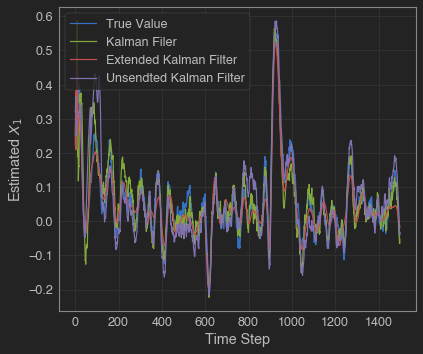

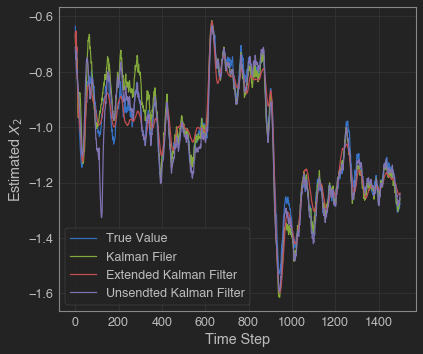

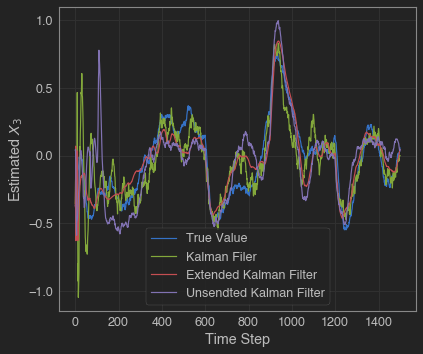

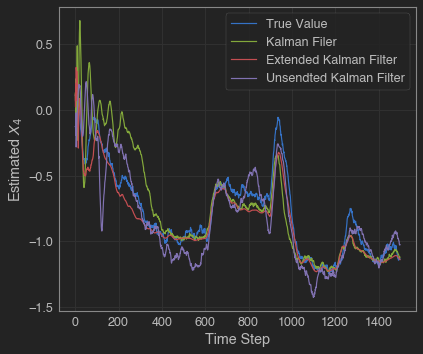

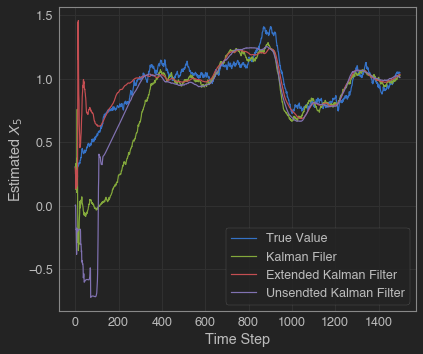

In [15]:
plt.plot(Xall[:, 0])
plt.plot(Xstorekf[:, 0])
plt.plot(Xstoreekf[:, 0])
plt.plot(Xstoreukf[:, 0])
plt.ylabel('Estimated $X_1$')
plt.xlabel('Time Step')
plt.legend(['True Value', 'Kalman Filer', 'Extended Kalman Filter', 'Unsendted Kalman Filter'])
plt.savefig('x1.png')
plt.show()

plt.plot(Xall[:, 1])
plt.plot(Xstorekf[:, 1])
plt.plot(Xstoreekf[:, 1])
plt.plot(Xstoreukf[:, 1])
plt.ylabel('Estimated $X_2$')
plt.xlabel('Time Step')
plt.legend(['True Value', 'Kalman Filer', 'Extended Kalman Filter', 'Unsendted Kalman Filter'])
plt.savefig('x2.png')
plt.show()

plt.plot(Xall[:, 2])
plt.plot(Xstorekf[:, 2])
plt.plot(Xstoreekf[:, 2])
plt.plot(Xstoreukf[:, 2])
plt.ylabel('Estimated $X_3$')
plt.xlabel('Time Step')
plt.legend(['True Value', 'Kalman Filer', 'Extended Kalman Filter', 'Unsendted Kalman Filter'])
plt.savefig('x3.png')
plt.show()


plt.plot(Xall[:, 3])
plt.plot(Xstorekf[:, 3])
plt.plot(Xstoreekf[:, 3])
plt.plot(Xstoreukf[:, 3])
plt.ylabel('Estimated $X_4$')
plt.xlabel('Time Step')
plt.legend(['True Value', 'Kalman Filer', 'Extended Kalman Filter', 'Unsendted Kalman Filter'])
plt.savefig('x4.png')
plt.show()


plt.plot(Xall[:, 4])
plt.plot(Xstorekf[:, 4])
plt.plot(Xstoreekf[:, 4])
plt.plot(Xstoreukf[:, 4])
plt.ylabel('Estimated $X_5$')
plt.xlabel('Time Step')
plt.legend(['True Value', 'Kalman Filer', 'Extended Kalman Filter', 'Unsendted Kalman Filter'])
plt.savefig('x5.png')
plt.show()

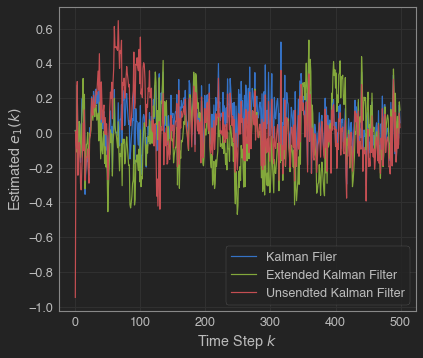

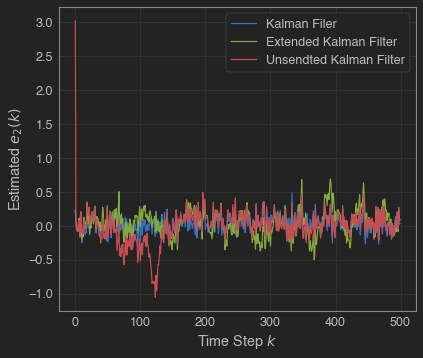

In [16]:
plt.plot(Eykf[:500, 0])
plt.plot(Eyekf[:500, 0])
plt.plot(Eyukf[:500, 0])
plt.ylabel('Estimated $e_1(k)$')
plt.xlabel('Time Step $k$')
plt.legend(['Kalman Filer', 'Extended Kalman Filter', 'Unsendted Kalman Filter'])
plt.savefig('e1y.png')
plt.show()


plt.plot(Eykf[:500, 1])
plt.plot(Eyekf[:500, 1])
plt.plot(Eyukf[:500, 1])
plt.ylabel('Estimated $e_2(k)$')
plt.xlabel('Time Step $k$')
plt.legend(['Kalman Filer', 'Extended Kalman Filter', 'Unsendted Kalman Filter'])
plt.savefig('e2y.png')
plt.show()

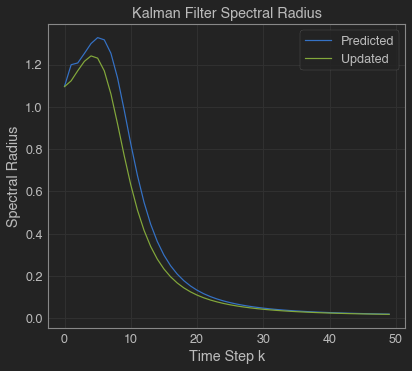

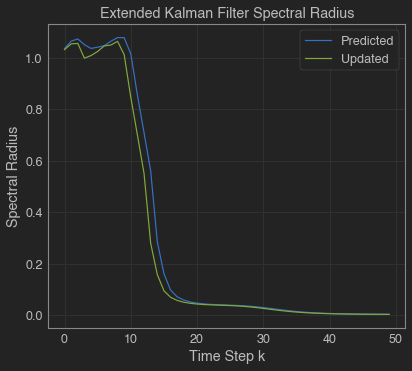

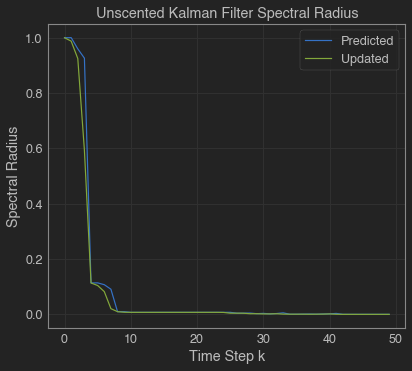

In [17]:
plt.plot(Rpkf[:50])
plt.plot(Rukf[:50])
plt.xlabel('Time Step k')
plt.ylabel('Spectral Radius')
plt.legend(['Predicted', 'Updated'])
plt.title('Kalman Filter Spectral Radius')
plt.savefig('srkf.png')
plt.show()

plt.plot(Rpekf[:50])
plt.plot(Ruekf[:50])
plt.xlabel('Time Step k')
plt.ylabel('Spectral Radius')
plt.legend(['Predicted', 'Updated'])
plt.title('Extended Kalman Filter Spectral Radius')
plt.savefig('srekf.png')
plt.show()

plt.plot(Rpukf[:50])
plt.plot(Ruukf[:50])
plt.xlabel('Time Step k')
plt.ylabel('Spectral Radius')
plt.legend(['Predicted', 'Updated'])
plt.title('Unscented Kalman Filter Spectral Radius')
plt.savefig('srukf.png')
plt.show()

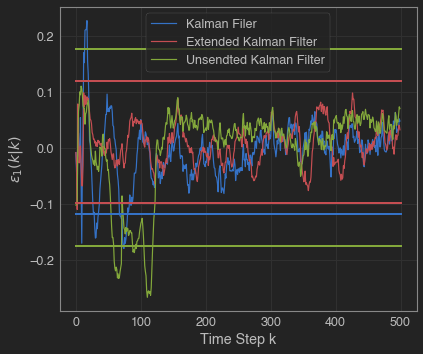

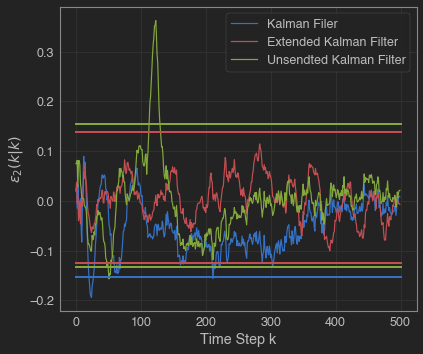

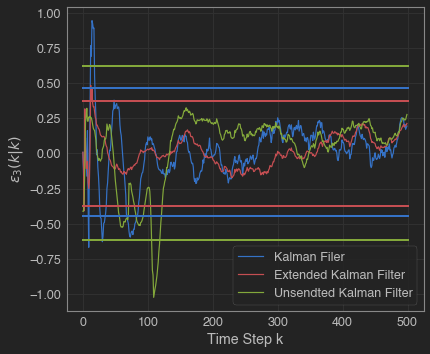

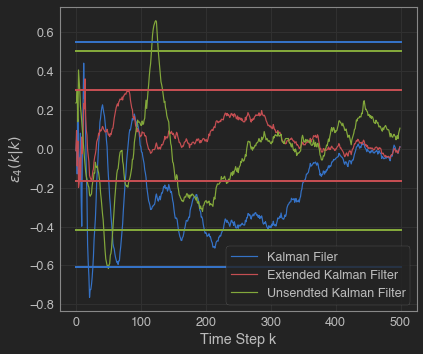

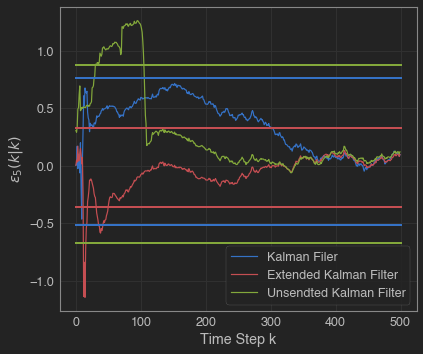

In [18]:
n=500
plt.plot(Exkf[:n, 0], 'b')
plt.plot(Exekf[:n, 0], 'r')
plt.plot(Exukf[:n, 0], 'g')
dkf=np.std(Exkf[:, 0])
mkf=np.average(Exkf[:, 0])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'b-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'b-', lw=2)
dkf=np.std(Exekf[:, 0])
mkf=np.average(Exekf[:, 0])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'r-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'r-', lw=2)
dkf=np.std(Exukf[:, 0])
mkf=np.average(Exukf[:, 0])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'g-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'g-', lw=2)
plt.xlabel('Time Step k')
plt.ylabel('$\epsilon_1(k|k)$')
plt.legend(['Kalman Filer','Extended Kalman Filter', 'Unsendted Kalman Filter'])
plt.savefig('ex1.png')
plt.show()

plt.plot(Exkf[:n, 1], 'b')
plt.plot(Exekf[:n, 1], 'r')
plt.plot(Exukf[:n, 1], 'g')
dkf=np.std(Exkf[:, 1])
mkf=np.average(Exkf[:, 1])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'b-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'b-', lw=2)
dkf=np.std(Exekf[:, 1])
mkf=np.average(Exekf[:, 1])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'r-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'r-', lw=2)
dkf=np.std(Exukf[:, 1])
mkf=np.average(Exukf[:, 1])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'g-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'g-', lw=2)
plt.xlabel('Time Step k')
plt.ylabel('$\epsilon_2(k|k)$')
plt.legend(['Kalman Filer','Extended Kalman Filter', 'Unsendted Kalman Filter'])
plt.savefig('ex2.png')
plt.show()

plt.plot(Exkf[:n, 2], 'b')
plt.plot(Exekf[:n, 2], 'r')
plt.plot(Exukf[:n, 2], 'g')
dkf=np.std(Exkf[:, 2])
mkf=np.average(Exkf[:, 2])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'b-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'b-', lw=2)
dkf=np.std(Exekf[:, 2])
mkf=np.average(Exekf[:, 2])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'r-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'r-', lw=2)
dkf=np.std(Exukf[:, 2])
mkf=np.average(Exukf[:, 2])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'g-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'g-', lw=2)
plt.xlabel('Time Step k')
plt.ylabel('$\epsilon_3(k|k)$')
plt.legend(['Kalman Filer','Extended Kalman Filter', 'Unsendted Kalman Filter'])
plt.savefig('ex3.png')
plt.show()

plt.plot(Exkf[:n, 3], 'b')
plt.plot(Exekf[:n, 3], 'r')
plt.plot(Exukf[:n, 3], 'g')
dkf=np.std(Exkf[:, 3])
mkf=np.average(Exkf[:, 3])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'b-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'b-', lw=2)
dkf=np.std(Exekf[:, 3])
mkf=np.average(Exekf[:, 3])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'r-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'r-', lw=2)
dkf=np.std(Exukf[:, 3])
mkf=np.average(Exukf[:, 3])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'g-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'g-', lw=2)
plt.xlabel('Time Step k')
plt.ylabel('$\epsilon_4(k|k)$')
plt.legend(['Kalman Filer','Extended Kalman Filter', 'Unsendted Kalman Filter'])
plt.savefig('ex4.png')
plt.show()

plt.plot(Exkf[:n, 4], 'b')
plt.plot(Exekf[:n, 4], 'r')
plt.plot(Exukf[:n, 4], 'g')
dkf=np.std(Exkf[:, 4])
mkf=np.average(Exkf[:, 4])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'b-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'b-', lw=2)
dkf=np.std(Exekf[:, 4])
mkf=np.average(Exekf[:, 4])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'r-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'r-', lw=2)
dkf=np.std(Exukf[:, 4])
mkf=np.average(Exukf[:, 4])
plt.plot([0, n], [mkf-3*dkf, mkf-3*dkf], 'g-', lw=2)
plt.plot([0, n], [mkf+3*dkf, mkf+3*dkf], 'g-', lw=2)
plt.xlabel('Time Step k')
plt.ylabel('$\epsilon_5(k|k)$')
plt.legend(['Kalman Filer','Extended Kalman Filter', 'Unsendted Kalman Filter'])
plt.savefig('ex5.png')
plt.show()

In [19]:
print('Average Ey1 KF:'+str(np.average(Eykf[:, 0])))
print('Average Ey2 KF:'+str(np.average(Eykf[:, 1])))
print('Average Ey1 EKF:'+str(np.average(Eyekf[:, 0])))
print('Average Ey2 EKF:'+str(np.average(Eyekf[:, 1])))
print('Average Ey1 UKF:'+str(np.average(Eyukf[:, 0])))
print('Average Ey2 UKF:'+str(np.average(Eyukf[:, 1])))
print()
print('Std Ey1 KF:'+str(np.std(Eykf[:, 0])))
print('Std Ey2 KF:'+str(np.std(Eykf[:, 1])))
print('Std Ey1 EKF:'+str(np.std(Eyekf[:, 0])))
print('Std Ey2 EKF:'+str(np.std(Eyekf[:, 1])))
print('Std Ey1 UKF:'+str(np.std(Eyukf[:, 0])))
print('Std Ey2 UKF:'+str(np.std(Eyukf[:, 1])))

Average Ey1 KF:0.009244014340088839
Average Ey2 KF:0.007869464837995426
Average Ey1 EKF:-0.051183355671589784
Average Ey2 EKF:0.04191619127802274
Average Ey1 UKF:-0.0020494652998989038
Average Ey2 UKF:-0.006862693966252347

Std Ey1 KF:0.13723307776687635
Std Ey2 KF:0.13079359178823305
Std Ey1 EKF:0.18744863541451007
Std Ey2 EKF:0.20003370187339878
Std Ey1 UKF:0.15662705465958546
Std Ey2 UKF:0.1897558166990819


In [20]:
def RMSp(E):
    s=0
    xm=np.average(X)
    for i in E:
        s+=i**2
    s=s/len(E)
    return sqrt(s)

In [21]:
print('For KF')
print('For X1 '+str(RMSp(Exkf[:, 0])))
print('For X2 '+str(RMSp(Exkf[:, 1])))
print('For X3 '+str(RMSp(Exkf[:, 2])))
print('For X4 '+str(RMSp(Exkf[:, 3])))
print('For X5 '+str(RMSp(Exkf[:, 4])))
print()
print('For EKF')
print('For X1 '+str(RMSp(Exekf[:, 0])))
print('For X2 '+str(RMSp(Exekf[:, 1])))
print('For X3 '+str(RMSp(Exekf[:, 2])))
print('For X4 '+str(RMSp(Exekf[:, 3])))
print('For X5 '+str(RMSp(Exekf[:, 4])))
print()
print('For UKF')
print('For X1 '+str(RMSp(Exukf[:, 0])))
print('For X2 '+str(RMSp(Exukf[:, 1])))
print('For X3 '+str(RMSp(Exukf[:, 2])))
print('For X4 '+str(RMSp(Exukf[:, 3])))
print('For X5 '+str(RMSp(Exukf[:, 4])))

For KF
For X1 0.03945836559981589
For X2 0.049241769907565354
For X3 0.1524966747352067
For X4 0.19497114402553517
For X5 0.24763189138616973

For EKF
For X1 0.037880928682600186
For X2 0.04462068931961477
For X3 0.12386161072287391
For X4 0.10395389378759444
For X5 0.11444800007206787

For UKF
For X1 0.05875318856037259
For X2 0.04940671104758977
For X3 0.20596039689110318
For X4 0.15901237903216736
For X5 0.27921714454536484


In [22]:
c1=scipy.stats.chi2.ppf(0.05, df=5)
c2=scipy.stats.chi2.ppf(0.95, df=5)

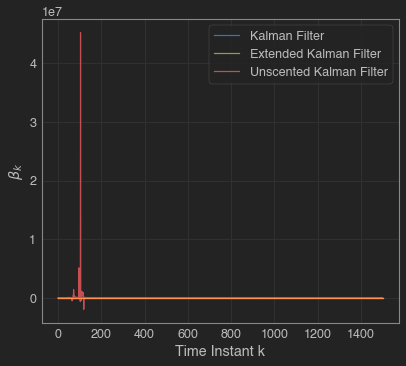

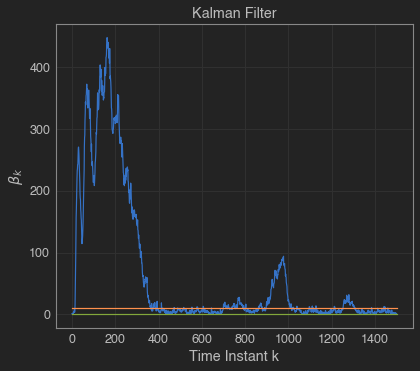

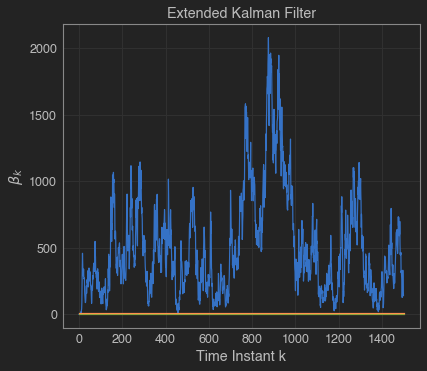

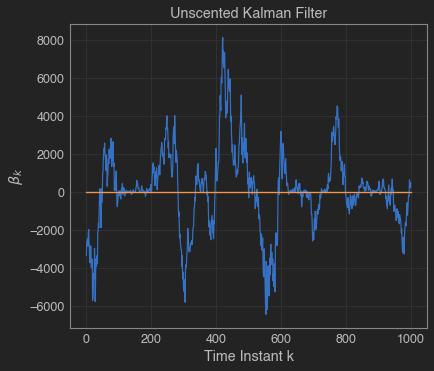

In [23]:
def PA(Bk):  
    n=0
    for i in Bk:
        if c1>=i or i>=c2:
            n+=1
    return n/len(Bk)

plt.plot(Bkkf)
plt.plot(Bkekf)
plt.plot(Bkukf)
plt.plot([0, 1500], [c1, c1], '-g')
plt.plot([0, 1500], [c2, c2], '-y')
plt.xlabel('Time Instant k')
plt.ylabel('$\\beta_k$')
plt.legend(['Kalman Filter', 'Extended Kalman Filter', 'Unscented Kalman Filter'])
plt.savefig('Allbk.png')
plt.show()

plt.plot(Bkkf)
plt.xlabel('Time Instant k')
plt.ylabel('$\\beta_k$')
plt.title('Kalman Filter')
plt.plot([0, 1500], [c1, c1], '-g')
plt.plot([0, 1500], [c2, c2], '-y')
plt.savefig('kfbk.png')
plt.show()

plt.plot(Bkekf)
plt.xlabel('Time Instant k')
plt.ylabel('$\\beta_k$')
plt.title('Extended Kalman Filter')
plt.plot([0, 1500], [c1, c1], '-g')
plt.plot([0, 1500], [c2, c2], '-y')
plt.savefig('ekfbk.png')
plt.show()

plt.plot(Bkukf[500:])
plt.xlabel('Time Instant k')
plt.ylabel('$\\beta_k$')
plt.title('Unscented Kalman Filter')
plt.plot([0, 1000], [c1, c1], '-g')
plt.plot([0, 1000], [c2, c2], '-y')
plt.savefig('ukfbk.png')
plt.show()

In [24]:
print('For KF, fraction not in limits is '+str(PA(Bkkf)))
print('For EKF, fraction not in limits is '+str(PA(Bkekf)))
print('For UKF, fraction not in limits is '+str(PA(Bkukf)))

For KF, fraction not in limits is 0.46066666666666667
For EKF, fraction not in limits is 0.9946666666666667
For UKF, fraction not in limits is 0.9886666666666667


In [25]:
print('For KF in steady state, fraction not in limits is '+str(PA(Bkkf[500:])))
print('For EKF in steady state, fraction not in limits is '+str(PA(Bkekf[500:])))
print('For UKF in steady state, fraction not in limits is '+str(PA(Bkukf[500:])))

For KF in steady state, fraction not in limits is 0.316
For EKF in steady state, fraction not in limits is 1.0
For UKF in steady state, fraction not in limits is 0.986


In [26]:
c=IMotor()

In [27]:
c1

1.1454762260617692

In [28]:
c2

11.070497693516351

In [29]:
Xsteady

array([ 0.01378041, -0.99746648,  0.00156055, -0.96124106,  0.99386274])

In [30]:
a=IMotor()
X5=[]
Z=[1, 1, 0]
T=0.1
for i in range(500):
    a.update2(T, Z)
    X5.append(a.getState()[-1])

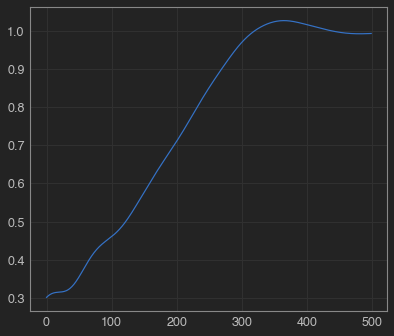

In [31]:
plt.plot(X5)

In [49]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [59]:

%watermark -v -m
%watermark --iversions

print(" ")
%watermark -u -n -t -z

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 19.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

scipy        : 1.5.2
matplotlib   : 3.3.2
numpy        : 1.19.2
jupyterthemes: 0.20.0

 
Last updated: Wed Jan 06 2021 12:27:33IST



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot as jlt
jlt.style()
from math import *
import random
import scipy.linalg as sp
random.seed(1)
import scipy.stats